# Final modification 
## change the unit of Hv
## operations set without exp, log.. add ^3,1/x..
### second featrues space: with only 2 or 3 parameters

In [1]:
import os
import pandas as pd
import numpy as np
from itertools import combinations
from time import time
import matplotlib.pyplot as plt 
import scipy.stats as ss
import warnings
from collections import Counter
from sklearn.kernel_ridge import KernelRidge
from IPython.display import HTML
from jupyter_jsmol import JsmolView
import itertools
import functools
import math
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


import combine_features as cf
warnings.filterwarnings('ignore')
pd.set_option('mode.use_inf_as_na', True)

In [2]:
print (os.path.abspath('.'))

/Users/zy/Desktop/lasso+l0_abrasion_FV


In [3]:
df = pd.read_csv("groupB.csv")
df.head()
ColNames = df.columns
print(ColNames)
df.head()

Index(['Sample No.', 'Hv\n(kg/mm2)', 'UTS\n(MPa)', 'YS\n(MPa)', 'UE\n(%)',
       'ETF\n(104 Pa)', 'K (MPa)', 'n', 'WL(g)'],
      dtype='object')


,Sample No.,Hv (kg/mm2),UTS (MPa),YS (MPa),UE (%),ETF (104 Pa),K (MPa),n,WL(g)
0,B-1,204,620,375,16.23,15491,1048,0.19,0.6420
1,B-2,318,973,767,5.55,7392,1940,0.18,0.5588
2,B-3,193,625,381,16.23,15470,1064,0.19,0.6219
3,B-4,319,1032,770,7.45,12288,1893,0.17,0.5056
4,B-5,458,1291,1119,2.65,7779,3029,0.20,0.4820


In [4]:
df.rename(columns={'ETF\n(104 Pa)':'ETF(MPa)'},inplace=True)
df['ETF(MPa)']=df['ETF(MPa)']/100 # 把etf的单位变为mpa
df.columns=['Sample No.','Hv','UTS','YS','UE','ETF','K','n','WL']
df['UE']=df['UE']/100 # 把ue变成小数
df['Hv']=df['Hv']*9.8  #change the unit of Hv into MPa
#df.to_excel("/Users/zy/Desktop/lasso+l0_abrasion_FV/GA_data.xls", index=False)
df.head()

,Sample No.,Hv,UTS,YS,UE,ETF,K,n,WL
0,B-1,1999.2,620,375,0.1623,154.91,1048,0.19,0.6420
1,B-2,3116.4,973,767,0.0555,73.92,1940,0.18,0.5588
2,B-3,1891.4,625,381,0.1623,154.70,1064,0.19,0.6219
3,B-4,3126.2,1032,770,0.0745,122.88,1893,0.17,0.5056
4,B-5,4488.4,1291,1119,0.0265,77.79,3029,0.20,0.4820


In [5]:
df.drop(['Sample No.'],axis=1,inplace=True)

df.head()

,Hv,UTS,YS,UE,ETF,K,n,WL
0,1999.2,620,375,0.1623,154.91,1048,0.19,0.6420
1,3116.4,973,767,0.0555,73.92,1940,0.18,0.5588
2,1891.4,625,381,0.1623,154.70,1064,0.19,0.6219
3,3126.2,1032,770,0.0745,122.88,1893,0.17,0.5056
4,4488.4,1291,1119,0.0265,77.79,3029,0.20,0.4820


一、定义operations set{+,-,*,/,^2}

In [6]:
##二元函数
_my_sum = lambda x:np.sum(x)
_my_diff= lambda x:np.diff(x)
_my_abs_diff= lambda x:np.abs(_my_diff(x))

_my_power_2=lambda x: np.power(x,2)
#_my_power_3=lambda x: x**3


def _my_div(x):
    return x[0]/x[1]
_my_mul= lambda x:np.prod(x)

In [7]:


##一元函数
# _my_exp=lambda x: np.exp(x)
# _my_log= lambda x : math.log(x)
def _my_power_n(x):
    
    a=np.power(x,df['n'])
    a.astype(np.int)
    #print(a.dtype)
    return a
def _my_sum_power_2(x):
    return np.square(_my_sum(x))
def _my_diff_power_2(x):
    return np.square(_my_diff(x))





In [8]:
def combine_features(df=None, allowed_operations=None, is_print=True):
### generate combinatons of features by given a dataframe and a list of allowed operations.
    if is_print:
        if allowed_operations:
            print('Selected operations:\\n {0}'.format(allowed_operations))
        else:
            print('No allowed operations selected.')
        columns_ = df.columns.tolist()
    dict_features={
        ## 变量分类
        'UTS':'a1',
        'YS':'a1',
        'ETF':'a1',
        'K':'a1',
        'Hv':'a1', 
        
        'UE':'a2',
        'n':'a2',
    
        }
    df_a1 = df[[col for col in columns_ if dict_features.get(col.split('(', 1)[0])=='a1']].astype('float32')
    df_a2 = df[[col for col in columns_ if dict_features.get(col.split('(', 1)[0])=='a2']].astype('float32')
  
    col_a1 = df_a1.columns.tolist()
    col_a2 = df_a2.columns.tolist()

    ## this list will at the end all the dataframes created\n',
    df_list = []
    
    df_b1_list = []
    df_b2_list = []
    df_c1_list = []
    df_c2_list = []
    df_d1_list = []
    df_d2_list = []
    df_e_list = []
    
    df_x1_list = []
    df_x2_list = []

    # create b1: absolute differences and sums of a1
    for subset in itertools.combinations(col_a1,2):
        if '+' in allowed_operations:
            cols = ['('+subset[0]+'+'+subset[1]+')']
            data = df_a1[list(subset)].apply(_my_sum,axis=1)
            df_b1_list.append(pd.DataFrame(data,columns=cols))
            
#         if '-' in allowed_operations:
#             cols = ['('+subset[1]+'-'+subset[0]+')']
#             data = df_a1[list(subset)].apply(_my_diff,axis=1)
#             df_b1_list.append(pd.DataFrame(data,columns=cols))
            
        if '|-|' in allowed_operations:
            cols = ['|'+subset[1]+'-'+subset[0]+'|']
            data = df_a1[list(subset)].apply(_my_abs_diff,axis=1)
            df_b1_list.append(pd.DataFrame(data,columns=cols))
            
                   
    #create b2: abs diff and sums of a2:
    for subset in itertools.combinations(col_a2,2):
        if '+' in allowed_operations:
            cols = ['('+subset[0]+'+'+subset[1]+')']
            data = df_a2[list(subset)].apply(_my_sum,axis=1)
            df_b2_list.append(pd.DataFrame(data,columns=cols))

            
#         if '-' in allowed_operations:
#             cols = ['('+subset[1]+'-'+subset[0]+')']
#             data = df_a2[list(subset)].apply(_my_diff,axis=1)
#             df_b2_list.append(pd.DataFrame(data,columns=cols))

            
        if '|-|' in allowed_operations:
            cols = ['|'+subset[1]+'-'+subset[0]+'|']
            data = df_a2[list(subset)].apply(_my_abs_diff,axis=1)
            df_b2_list.append(pd.DataFrame(data,columns=cols))
            
    # create c1:^2 of a1:
    for subset in itertools.combinations(col_a1,1):

        if '^2' in allowed_operations:
            cols = ['('+subset[0]+'^2'+')']       
            f = df_a1[list(subset)].apply(_my_power_2,axis=1)
            data=f.values
            df_c1_list.append(pd.DataFrame(data,columns=cols))
#         if '^3' in allowed_operations:
#             cols = ['('+subset[0]+'^3'+')']       
#             f = df_a1[list(subset)].apply(_my_power_3,axis=1)
#             data=f.values
#             df_c1_list.append(pd.DataFrame(data,columns=cols))
            
    # create c2:^2 of a2:
    for subset in itertools.combinations(col_a2,1):

        if '^2' in allowed_operations:
            cols = ['('+subset[0]+'^2'+')']       
            f = df_a2[list(subset)].apply(_my_power_2,axis=1)
            data=f.values
            df_c2_list.append(pd.DataFrame(data,columns=cols))
#         if '^3' in allowed_operations:
#             cols = ['('+subset[0]+'^3'+')']       
#             f = df_a2[list(subset)].apply(_my_power_3,axis=1)
#             data=f.values
#             df_c2_list.append(pd.DataFrame(data,columns=cols))

    # create d1:^2 of b1:               
    for subset in itertools.combinations(col_a1, 2):

        if '^2' in allowed_operations:
            cols = ['('+subset[0]+'+'+subset[1]+')'+'^2']       
            f = df_a1[list(subset)].apply(_my_sum_power_2,axis=1)
            data=f.values
            df_d1_list.append(pd.DataFrame(data,columns=cols))
            cols = ['('+subset[0]+'-'+subset[1]+')'+'^2']       
            f = df_a1[list(subset)].apply(_my_diff_power_2,axis=1)
            data=f.values
            df_d1_list.append(pd.DataFrame(data,columns=cols))
       
    # create d2:^2 of b2:
    for subset in itertools.combinations(col_a2, 2):

        if '^2' in allowed_operations:
            cols = ['('+subset[0]+'+'+subset[1]+')'+'^2']       
            f = df_a2[list(subset)].apply(_my_sum_power_2,axis=1)
            data=f.values
            df_d2_list.append(pd.DataFrame(data,columns=cols))
            cols = ['('+subset[0]+'-'+subset[1]+')'+'^2']       
            f = df_a2[list(subset)].apply(_my_diff_power_2,axis=1)
            data=f.values
            df_d2_list.append(pd.DataFrame(data,columns=cols))
            

             
        
    if not df_a1.empty: 
        df_x1_list.append(df_a1)
        df_list.append(df_a1)
        
    if not df_a2.empty: 
        df_x2_list.append(df_a2)
        df_list.append(df_a2)

        
    if df_b1_list: 
        df_b1 = pd.concat(df_b1_list, axis=1)
        col_b1 = df_b1.columns.tolist()
        #df_x1_list.append(df_b1)
        df_list.append(df_b1)

    if df_b2_list: 
        df_b2 = pd.concat(df_b2_list, axis=1)
        col_b2 = df_b2.columns.tolist()
        #df_x1_list.append(df_b2)
        df_list.append(df_b2)
        
    if df_c1_list: 
        df_c1 = pd.concat(df_c1_list, axis=1)
        col_c1 = df_c1.columns.tolist()
        df_x1_list.append(df_c1)
        df_list.append(df_c1)
    if df_c2_list: 
        df_c2 = pd.concat(df_c2_list, axis=1)
        col_c2 = df_c2.columns.tolist()
        df_x2_list.append(df_c2)
        df_list.append(df_c2)
    if df_d1_list: 
        df_d1 = pd.concat(df_d1_list, axis=1)
        col_d1 = df_d1.columns.tolist()
        #df_x1_list.append(df_c1)
        df_list.append(df_d1)
    if df_d2_list: 
        df_d2 = pd.concat(df_d2_list, axis=1)
        col_d2 = df_d2.columns.tolist()
        #df_x1_list.append(df_c2)
        df_list.append(df_d2)
        
    if df_x1_list:
        df_x1 = pd.concat(df_x1_list, axis=1)
        col_x1 = df_x1.columns.tolist()
        
    if df_x2_list:
        df_x2 = pd.concat(df_x2_list, axis=1)
        col_x2 = df_x2.columns.tolist()
        
    #create e: mul and ratios of X1 with X2:
    if df_x1_list and df_x2_list:    
        for sub_x1 in col_x1:
            for sub_x2 in col_x2:
                if '*' in allowed_operations:
                    cols = [sub_x1+'*'+sub_x2] 
                    #now the operation is between two dataframes\n',
                    data=df_x1[sub_x1].multiply(df_x2[sub_x2])
                    df_e_list.append(pd.DataFrame(data, columns=cols)) 
                if '/' in allowed_operations:
                    cols = [sub_x1+'/'+sub_x2] 
                    #now the operation is between two dataframes\n',
                    data=df_x1[sub_x1].divide(df_x2[sub_x2])
                    df_e_list.append(pd.DataFrame(data, columns=cols)) 
                    #reverse
                    cols = [sub_x2+'/'+sub_x1] 
                    data=df_x2[sub_x2].divide(df_x1[sub_x1])
                    df_e_list.append(pd.DataFrame(data, columns=cols)) 
                    
#     if df_d_list:
#         df_d=pd.concat(df_d_list,axis=1)
#         col_d=df_d.columns.tolist()
#         df_list.append(df_d)
    if df_e_list:
        df_e=pd.concat(df_e_list,axis=1)
        col_e=df_e.columns.tolist()
        df_list.append(df_e)

    if df_list:
        df_combined_features = pd.concat(df_list, axis=1)
        #print(len(df_b1_list),len(df_b2_list),len(df_d_list),len(df_e_list))
    elif is_print:
        print('No features selected. Please select at least two primary features.')


    if is_print:
        print('Number of total features generated: {0}'.format(df_combined_features.shape[1]))

    return df_combined_features 
            

In [9]:
def get_data(selected_feature_list, allowed_operations):
    # extract WEARLOSS and selected features from df_data 
    P = df['WL'].values
    df_features = df[selected_feature_list]
    
    # derive new features using allowed_operations
    df_combined = combine_features(df=df_features, allowed_operations=allowed_operations)
    return P, df_combined

In [10]:
#import Data
selected_feature_list = ['UE','Hv','UTS','YS','n','ETF','K']
allowed_operations = ['+','-','|-|','/','*','^2']



P, df_D = get_data(selected_feature_list, allowed_operations)
print(len(list(df_D)))
df_D.replace([np.inf, -np.inf], np.nan,inplace=True)
df_D =df_D.dropna(axis=1)
df_D = df_D.loc[:, (df_D != 0).any(axis=0)]

print(len(list(df_D)))


D = df_D.values
D = D.astype(np.float64)
features_list = df_D.columns.tolist()
df_D.info()
df_D.isna().values.any()



Selected operations:\n ['+', '-', '|-|', '/', '*', '^2']
Number of total features generated: 178
178
178
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 178 entries, Hv to (n^2)/(K^2)
dtypes: float32(134), float64(22), object(22)
memory usage: 17.4+ KB


False

In [11]:
pd.set_option('display.width', 10)  # 设置字符显示宽度
pd.set_option('display.max_rows', None)  # 设置显示最大行
print(df_D.iloc[0])
df_D.iloc[0].isnull().values.any()

Hv                         1999.2
UTS                           620
YS                            375
ETF                        154.91
K                            1048
UE                         0.1623
n                            0.19
(Hv+UTS)                   2619.2
|UTS-Hv|                 [1379.2]
(Hv+YS)                    2374.2
|YS-Hv|                  [1624.2]
(Hv+ETF)                  2154.11
|ETF-Hv|              [1844.2899]
(Hv+K)                     3047.2
|K-Hv|                [951.19995]
(UTS+YS)                      995
|YS-UTS|                  [245.0]
(UTS+ETF)                  774.91
|ETF-UTS|                [465.09]
(UTS+K)                      1668
|K-UTS|                   [428.0]
(YS+ETF)                   529.91
|ETF-YS|                 [220.09]
(YS+K)                       1423
|K-YS|                    [673.0]
(ETF+K)                   1202.91
|K-ETF|               [893.08997]
(UE+n)                     0.3523
|n-UE|              [0.027699992]
(Hv^2)        

False

In [12]:
#standardize data
D_standardized = ss.zscore(D)
print(D_standardized.shape)
print(type(D_standardized))
np.isnan(D_standardized).any()
#print(np.isnan(D_standardized).any(axis=0))
D_standardized=D_standardized[:, ~np.isnan(D_standardized).any(axis=0)]

(20, 178)
<class 'numpy.ndarray'>


In [13]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, D_standardized, P, 
                                   scoring="neg_mean_squared_error", cv = 5))
    return(rmse)



In [14]:
##cv调参2
# 根据上图建立Lasso进行alpha选择的范围
alpha_range = np.linspace(0.1,0.001,70)

# # LassoCV
lasso_ = LassoCV(alphas=alpha_range,cv=5).fit(D_standardized,P)

# # 查看最佳正则化系数
best_alpha = lasso_.alpha_ 
print(best_alpha)




0.0024347826086956598


In [15]:
def rmse():
    
    P_predict = lasso.predict(D_standardized)
    #print(P_predict)
    RMSE_LASSO = np.linalg.norm(P-P_predict) / np.sqrt(20.)
    return RMSE_LASSO




In [16]:
from sklearn.metrics import r2_score
def r_2():
    P_predict = lasso.predict(D_standardized)
    return r2_score(P_predict,P)



In [17]:
#以线性关系改变lambda的值，观察非零系数的个数
from sklearn.linear_model import Lasso
alpha = np.linspace(0.07,0.0001,100)
m=0
lams=[]
rmse_s=[]
#table = PrettyTable(['NO.','alpha', 'num_nonzero','selected features','rmse','coef','r^2','intercept'])


for i in range(100):
    global m
    lasso=Lasso(alpha=alpha[i])
    lasso.fit(D_standardized,P)
    coef=lasso.coef_
    a=np.sum(coef != 0)
    
    if a!=m:
        m=a
        
#         print(m)
#         print(alpha[i])

        
    # get strings of selected features
        selected_indices = lasso.coef_.nonzero()[0]
        selected_features = [features_list[i] for i in selected_indices]
        #print(lasso.predict(D_standardized))
        #print(pd.DataFrame({'alpha':"%.3f" %alpha[i],'num_nonzero':m,'features_list':selected_features,'rmse':rmse_cv(),'coef':coef[coef.nonzero()].round(3)}))
        #print('alpha',"%.3f" %alpha[i],'num_nonzero',m,selected_features,'rmse',rmse_cv(),'coef',coef[coef.nonzero()].round(5))
        #pd.Series(index = ['Intercept'] + D_standardized.columns.tolist(),data = [lasso.intercept_] + lasso.coef_.tolist())
        #print(lasso.intercept_)
        if a<=36:
            #table.add_row([i,alpha[i].round(2),m,selected_features,rmse().round(2),coef[coef.nonzero()].round(2),lasso.intercept_.round(2),r_2()])
            print('alpha',"%.5f" %alpha[i],'num_nonzero',m,selected_features,'rmse',rmse().round(4),'coef',coef[coef.nonzero()].round(5),'截距:',lasso.intercept_.round(2),'\n','r_squared:',r_2().round(5))
            
            rmse_s.append(rmse)
            lams.append(alpha[i])



# print("lambda: %.3f\t dimension of descriptor: %s\t RMSE_LASSO: %.3f\t RMSE_LS: %.3f" 
#       %(lam, len(selected_features), RMSE_LASSO, RMSE_LS))
# print(pd.DataFrame({'features':np.array(selected_features), 'abs(nonzero_coefs_LASSO)': np.abs(coef[coef.nonzero()])}))
# plt.show()  

alpha 0.07000 num_nonzero 1 ['(ETF+K)^2'] rmse 0.0858 coef [-0.00811] 截距: 0.57 
 r_squared: -110.86342
alpha 0.06929 num_nonzero 2 ['|K-YS|', '(ETF+K)^2'] rmse 0.0852 coef [-0.00025 -0.00858] 截距: 0.57 
 r_squared: -92.36306
alpha 0.04741 num_nonzero 3 ['|K-YS|', '(ETF+K)^2', '(ETF^2)/UE'] rmse 0.068 coef [-1.147e-02 -1.985e-02 -9.000e-05] 截距: 0.57 
 r_squared: -3.82547
alpha 0.04176 num_nonzero 4 ['|K-YS|', '(ETF+K)^2', '(YS^2)*UE', '(ETF^2)/UE'] rmse 0.0633 coef [-0.01221 -0.02267 -0.00018 -0.00332] 截距: 0.57 
 r_squared: -1.96026
alpha 0.02058 num_nonzero 5 ['|K-YS|', '(ETF+K)^2', '(YS^2)*UE', '(ETF^2)/UE', '(K^2)/n'] rmse 0.0468 coef [-0.01858 -0.02913 -0.01219 -0.00708 -0.00048] 截距: 0.57 
 r_squared: 0.39016
alpha 0.01705 num_nonzero 6 ['|K-YS|', '(ETF+K)^2', '(YS^2)*UE', '(ETF^2)/UE', 'n/(ETF^2)', '(K^2)/n'] rmse 0.0444 coef [-0.02053 -0.02444 -0.01417 -0.00848  0.00024 -0.00542] 截距: 0.57 
 r_squared: 0.51762
alpha 0.01493 num_nonzero 7 ['|K-YS|', '(UTS+K)^2', '(ETF+K)^2', '(YS^2)*

In [18]:
model=Lasso(0.01281).fit(D_standardized,P)
coef=model.coef_
a=np.sum(coef != 0)
selected_indices = model.coef_.nonzero()[0]
selected_features = [features_list[i] for i in selected_indices]
print('num_nonzero',a,selected_features,'rmse',rmse(),'coef',coef[coef.nonzero()].round(8),'截距:',model.intercept_)





num_nonzero 9 ['|K-YS|', '(UTS+ETF)^2', '(UTS+K)^2', '(ETF+K)^2', '(YS^2)*UE', '(ETF^2)/UE', 'UE/(ETF^2)', 'n/(ETF^2)', '(K^2)/n'] rmse 0.006374680567410936 coef [-0.02976288 -0.0073367  -0.00932075 -0.00460886 -0.01312062 -0.00191865
  0.00101545  0.01150578 -0.01075014] 截距: 0.5676699999999999


In [19]:
#print(selected_features)
D_screened=df_D[selected_features]
D_= D_screened.values
D_= D_.astype(np.float64)
D_screened.info()
D_screened_standardized = ss.zscore(D_)
print(len(D_screened_standardized[0]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
|K-YS|         20 non-null object
(UTS+ETF)^2    20 non-null float64
(UTS+K)^2      20 non-null float64
(ETF+K)^2      20 non-null float64
(YS^2)*UE      20 non-null float32
(ETF^2)/UE     20 non-null float32
UE/(ETF^2)     20 non-null float32
n/(ETF^2)      20 non-null float32
(K^2)/n        20 non-null float32
dtypes: float32(5), float64(3), object(1)
memory usage: 1.1+ KB
9


In [20]:
def L0(P, D, dimension):
    n_rows, n_columns = D.shape
    D = np.column_stack((D, np.ones(n_rows)))
    SE_min = np.inner(P ,P)
    coef_min, permu_min = None, None
    for permu in combinations(range(n_columns), dimension):
        D_ls = D[:, permu + (-1,)]
        coef, SE, __1, __2 = np.linalg.lstsq(D_ls, P, rcond=-1)
        try:
            if SE[0] < SE_min: 
                SE_min = SE[0]
                coef_min, permu_min = coef, permu
        except:
            pass
    RMSE = np.sqrt(SE_min/n_rows)
    return RMSE, coef_min, permu_min

In [22]:
def L0_predict(coefficients,X,selected_indices):
    X = np.array(X)
    p=len(X)
    y_pred=[]
    n=len(selected_indices)
    X_selected=np.zeros(shape=((n,p)))
    w=coefficients
    m=len(coefficients)
    print('len(coefs)=',m)

    z=0
    for j in selected_indices:
        #print(X[:,j])
        #np.append(X_selected[z,:],X[:,j],axis=1)
        X_selected[z,:]=X[:,j]
        z=z+1
    #print('X_selected',X_selected) 
    #print('selected indices',n)
    for i in range(0,p):
        #print(i)
#         print('yes')
#         print(X_selected[i])
#         print(X_selected[i]* w[0:n] + w[n])
#         print(w[0:n])
#         print(w[n])

        #ele=w[0:m-1]*X_selected[:,i]+ w[m-1]
        ele=np.dot(w[0:m-1],X_selected[:,i])+w[m-1]
        #print(ele)
        #print(w[0:m-1],X_selected[:,i],w[m-1])
    
        y_pred.append(ele.round(4))
    #print(type(y_pred))
    
    
    return y_pred




In [23]:
#Result LASSO+L0
print("     RMSE   best desriptor")
for dim in range(1,2):
    RMSE, coefficients, selected_indices_l0 = L0(P,D_screened_standardized,dim)
    print(selected_features)
    print(selected_indices_l0)
    Y_pre=L0_predict(coefficients,D_screened_standardized,selected_indices_l0)
    print(Y_pre)
    score=r2_score(P,Y_pre)
    descriptor=[selected_features[i] for i in selected_indices_l0]
    print('%2sD: %.5f' % (dim, RMSE), [selected_features[i] for i in selected_indices_l0],coefficients,'score',score)
    df_B_2=df_D[descriptor]
    df_B_2.to_excel("/Users/zy/Desktop/lasso+l0_abrasion_FV/dfB2.xlsx")
    #print('y_pred:',y_pred(coefficients,D,selected_indices))

     RMSE   best desriptor
['|K-YS|', '(UTS+ETF)^2', '(UTS+K)^2', '(ETF+K)^2', '(YS^2)*UE', '(ETF^2)/UE', 'UE/(ETF^2)', 'n/(ETF^2)', '(K^2)/n']
(3,)
len(coefs)= 2
[0.6391, 0.5902, 0.6384, 0.59, 0.4853, 0.6225, 0.4858, 0.5409, 0.5315, 0.5924, 0.6015, 0.5284, 0.4856, 0.5239, 0.333, 0.6579, 0.5887, 0.6575, 0.6099, 0.6511]
 1D: 0.04957 ['(ETF+K)^2'] [-0.07810975  0.56767   ] score 0.7130044179690851


In [24]:
#Result by l0 directly
print("     RMSE   best desriptor")
for dim in range(1,2):
    RMSE, coefficients, selected_indices = L0(P,D_standardized,dim)
    #print(selected_indices)
    Y_pre=L0_predict(coefficients,D_standardized,selected_indices)
    print(Y_pre)
    score=r2_score(P,Y_pre)
    print('%2sD: %.5f' % (dim, RMSE), [features_list[i] for i in selected_indices],coefficients,'score',score)
    #print('y_pred:',y_pred(coefficients,D,selected_indices))

     RMSE   best desriptor
len(coefs)= 2
[0.6391, 0.5902, 0.6384, 0.59, 0.4853, 0.6225, 0.4858, 0.5409, 0.5315, 0.5924, 0.6015, 0.5284, 0.4856, 0.5239, 0.333, 0.6579, 0.5887, 0.6575, 0.6099, 0.6511]
 1D: 0.04957 ['(ETF+K)^2'] [-0.07810975  0.56767   ] score 0.7130044179690851


len(coefs)= 2
r^2= 0.7130044179690851


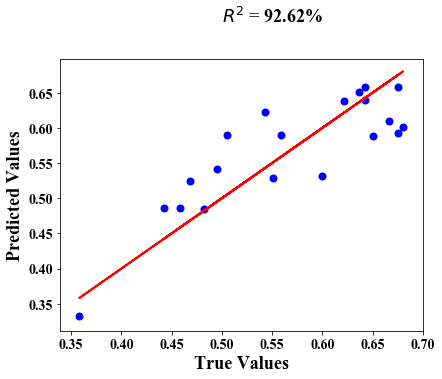

r^2= 0.7130044179690851


In [25]:
plt.rc('font',family='Times New Roman')  #定义字体

plt.figure(figsize=(6.5,5))    #设置图片大小

font1 = {'family' : 'Times New Roman',

'weight' : 'normal',

'size'   : 18,

}




plt.xticks(fontsize=14)       #设置坐标轴刻度字号

plt.yticks(fontsize=14)

x=df['WL']
true_values = np.array(x)

Y_pre=L0_predict(coefficients,D_screened_standardized,selected_indices_l0)
predicted_values=np.array(Y_pre)
y=x
plt.plot(x,y,linewidth=2,color='r')    #画图，第一条线，线宽为2,颜色用color设置
plt.scatter(true_values,predicted_values, linewidth=2,color='b')

# plt.plot(x,y,c='red')




# plt.plot(x,Y2,'-.',linewidth=2)

# plt.plot(x,Y3,'--',linewidth=2)

# plt.plot(x,Y4,':',linewidth=2)

# plt.plot(x,Y5,dashes=[8, 3],linewidth=2) #画图，第五条线，线型通过[8,3]修改

# plt.ylim(-0.001,0.01)                     #纵坐标范围

# plt.xlim(0,0.65)                          #横坐标范围

# plt.title('R',font1) #标题

plt.xlabel("True Values",font1)          #x轴名称

plt.ylabel("Predicted Values",font1)    #y轴名称

# plt.legend([r"$\beta_i=0$",r"$\beta_i=0.025$",r"$\beta_i=0.05$",r"$\beta_i=0.075$",r"$\beta_i=0.1$"],fontsize=14,edgecolor="black") #设置标注

# foo_fig=plt.gcf()

# foo_fig.savefig('figure1.eps',format='eps',dpi=1000)  #存储为eps格式，分辨率100dpi
print('r^2=',r2_score(true_values,predicted_values))


plt.text(0.5,0.75,r'$R^{2}$ = 92.62%',fontdict={'size':'18','color':'black'})
#保存图片，在plt.show()前进行
#plt.savefig("/Users/zy/Desktop/sisso_abraision_version0/GA_multi-factor2.png", format='png',dpi=300,bbox_inches='tight')

plt.show()
print('r^2=',r2_score(true_values,predicted_values))






r^2= 0.7129020894417923


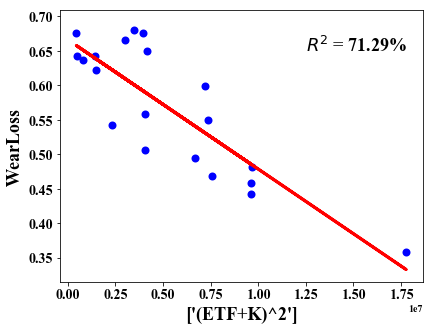

In [28]:
from sklearn.linear_model import LinearRegression


plt.rc('font',family='Times New Roman')  #定义字体

plt.figure(figsize=(6.5,5))    #设置图片大小

font1 = {'family' : 'Times New Roman',

'weight' : 'normal',

'size'   : 18,

}




plt.xticks(fontsize=14)       #设置坐标轴刻度字号

plt.yticks(fontsize=14)

x=df_D[descriptor]
plt.scatter(x,P, linewidth=2,color='b')

x_=x.values.reshape(-1,1)
model=LinearRegression()

model.fit(x_,y)
y_pred=model.predict(x_)


plt.plot(x_,y_pred,color='red',linewidth=3,label='best line')

print('r^2=',model.score(x_,y))

# plt.plot(x,y,c='red')




# plt.plot(x,Y2,'-.',linewidth=2)

# plt.plot(x,Y3,'--',linewidth=2)

# plt.plot(x,Y4,':',linewidth=2)

# plt.plot(x,Y5,dashes=[8, 3],linewidth=2) #画图，第五条线，线型通过[8,3]修改

# plt.ylim(-0.001,0.01)                     #纵坐标范围

# plt.xlim(0,0.65)                          #横坐标范围

# plt.title('R',font1) #标题

plt.xlabel(descriptor,font1)          #x轴名称

plt.ylabel("WearLoss",font1)    #y轴名称

# plt.legend([r"$\beta_i=0$",r"$\beta_i=0.025$",r"$\beta_i=0.05$",r"$\beta_i=0.075$",r"$\beta_i=0.1$"],fontsize=14,edgecolor="black") #设置标注

# foo_fig=plt.gcf()

# foo_fig.savefig('figure1.eps',format='eps',dpi=1000)  #存储为eps格式，分辨率100dpi
#print('r^2=',r2_score(true_values,predicted_values))


plt.text(12500000,0.65,r'$R^{2}$ = 71.29%',fontdict={'size':'18','color':'black'})
#保存图片，在plt.show()前进行
plt.savefig("/Users/zy/Desktop/sisso_abraision_version0/D2_B.png", format='png',dpi=300,bbox_inches='tight')

plt.show()
#print('r^2=',r2_score(true_values,predicted_values))







